# Predicting Amazon review ratings based only on the text using TF-IDF and Logistic Regression
 
In this exercise I will use a simple Logistic Regression model to explore if we can predict the rating of a Book review in Amazon based exclusively on the text of the review.
 
I will begin importing the libraries necessary to perform this exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we load a fraction of the dataset and visualize the head of the dataset that we obtained.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
res = list(books.aggregate([
    { "$sample": { "size": 75000 }}
    ,{ "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} 
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [3]:
df.head()

,overall,reviewerName,reviewText,summary,id
0,2,Loves to Sew,Disappointing. Starts with some laugh out lou...,Disappointing,6033ab7df7ccad4a92f3d76d
1,5,lakegirl41,One of my favorite authors. I never miss one ...,One of the best in the spy thiller genre,6033ab8cf7ccad4a92f6c897
2,2,Peter Finch,Blue Mars is a lousy book in a lousy trilogy. ...,"Longer than Foundation, more sand than Dune.",6033ab88f7ccad4a92f5f169
3,5,Denise Newcomer,Excellent as always and as Silva moves forward...,Excellent as always and as Silva moves forward...,6033ab92f7ccad4a92f8078f
4,5,Cal Gal,can't go wrong,Five Stars,6033ab7af7ccad4a92f32143


I wil now drop the rows with NaN values in the `reviewText` column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       75000 non-null  int64 
 1   reviewerName  74999 non-null  object
 2   reviewText    74988 non-null  object
 3   summary       74988 non-null  object
 4   id            75000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


In [5]:
df=df.dropna(subset=['reviewText'])

Let's check that everything is fine...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74988 entries, 0 to 74999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       74988 non-null  int64 
 1   reviewerName  74987 non-null  object
 2   reviewText    74988 non-null  object
 3   summary       74976 non-null  object
 4   id            74988 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


OK, so now I will examine the `overall` column, that is the target feature.
 
There are far more reviews with high ratings than with low scores, so there is no balance. To solve this, later on I will weight the clases instead of selecting now the exact number of reviews for each rating.

In [7]:
df["overall"].value_counts()

5    46888
4    15283
3     6984
2     3143
1     2690
Name: overall, dtype: int64

## Preprocessing: TF-IDF
 
I will create TF-IFD vectors for each review. TF-IDF measures the frequency of each word inside a review and compares it with the number of documents where this word appears. 
 
To begin with I will clean the review text ignoring stop words and words with less than 4 letters, as they will likely not contain much information.

In [8]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res



Now I will create a feature with the "cleaned" text named `review_clean`

In [9]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)
df=df.reset_index()

And then we can now create the TF-IDF vectors for each review using `TfidfVectorizer` from  `sklearn`. We ignore words that don't appear in at least 5 reviews.

But first, we need to split the dataset into train and test samples. I will choose 85% of the sample to train and 15% to test. 

The TF-IDF vectorizer needs to be trained first on the train dataset and after that applied to the test dataset, in order to prevent data leackage.

In [10]:
Xraw_train, Xraw_test, y_train, y_test = train_test_split(df["review_clean"], df["overall"], test_size=0.15, random_state=42)

v = TfidfVectorizer(min_df=5)
tf_idf_train = v.fit_transform(Xraw_train).toarray()
tf_idf_test = v.transform(Xraw_test).toarray()

X_train=pd.DataFrame(tf_idf_train, columns=v.get_feature_names())
X_test=pd.DataFrame(tf_idf_test, columns=v.get_feature_names())

Just for curiosity, let's check how many features/words the TF-IDF vectors have...

In [11]:
len(v.get_feature_names())

23244

In [12]:
len(y_train),len(y_test)

(63739, 11249)

## Logistic Regression: Predicting the scores based on the TF-IDF vectors

Now it's time to use the Logistic Regression model to predict the scores of the reviews. The TD-IFD vectors are the features used to predict the target, that is the `overall` column that stores the numeric ratings.
 
We will activate `class_weight="balanced"`, as the classes (scores) are not balanced, so if we do not weigh the classes the fit will be biased towards high ratings (most populated classes).
 
This is just a very simple approach, without fine tuning anything. This is just an exercise for learning purposes.

In [13]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)

/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


That's it? Well, now we need to check the performance of this model...

Let's check the score of the classification model for the train and test samples

In [14]:
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.69
Test sample classification score: 0.56


This seems just OK, but let's check an histogram to see the accuracy of the predictions by plotting the true score minus the predicted score.

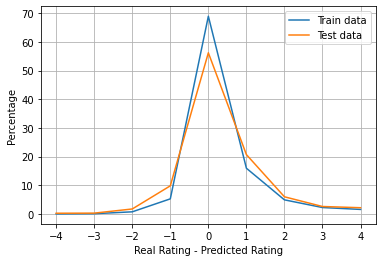

In [15]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

Well, this simple model seems not to be very wrong! Let's quantify this with the confusion matrices as well.

In [16]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 2124,    63,    45,    24,    36],
       [  131,  2281,   128,    47,    59],
       [  333,   533,  3987,   664,   409],
       [  401,   542,  1677,  7857,  2525],
       [ 1035,  1052,  2283,  7837, 27666]])

In [17]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 205,   97,   53,   10,   33],
       [ 138,  158,  132,   42,   27],
       [ 104,  188,  409,  252,  105],
       [  87,  148,  438,  982,  626],
       [ 249,  210,  425, 1566, 4565]])

And normalized to the true scores.

Train subsample:


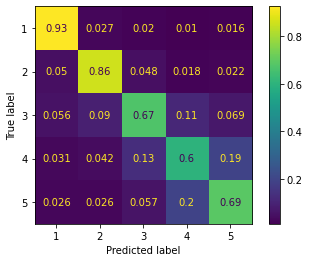

Test subsample:


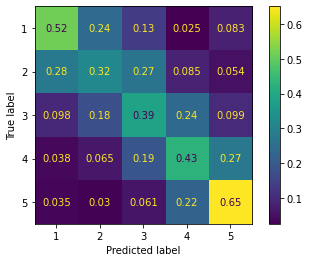

In [18]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

The diagonal indicates that the Logistic Model predicts reasonably well the score of the review for this simple approach.

## Undersanding the Logistic Regression: How it is pedicted

I will create a DataFrame with the coefficients of each score to understand how the features (words) contributes to each class.

In [19]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]
model.head(20)

,1,2,3,4,5
aaron,0.006770,0.444029,-0.246668,-0.099750,-0.104381
aback,-0.136760,0.179028,-0.190128,-0.040412,0.188272
abandon,0.414620,0.402075,-0.681850,-0.016647,-0.118198
abandoned,0.802181,1.176811,-1.007685,-0.254269,-0.717038
abandoning,0.254506,0.253936,-0.185365,-0.097050,-0.226027
abandonment,0.017719,-0.364044,0.306499,0.044739,-0.004913
abandons,-0.253358,0.325939,-0.052941,-0.016850,-0.002790
abarat,-0.291648,0.523662,0.039147,-0.548654,0.277493
abbey,0.353580,-0.724238,-0.160449,0.343803,0.187304
abbot,-0.119098,0.132476,-0.149685,0.123302,0.013005


For the highest score, the words that are directly correlated and contributes the most are words as "excellent", "great", "love", "fantastic", "amazing"...

In [20]:
model["5"].sort_values(ascending=False).head(20)

great          4.608426
wonderful      4.312812
highly         4.282987
excellent      3.995732
fantastic      3.882990
love           3.787973
amazing        3.692790
beautifully    3.630109
loved          3.433179
awesome        3.367438
perfect        3.270541
favorite       3.223673
wait           3.113690
beautiful      3.005391
fascinating    2.989929
outstanding    2.905683
loves          2.782816
every          2.623823
timeless       2.533979
fabulous       2.447075
Name: 5, dtype: float64

So, for the lowest score, it is not strange that the words that are directly correlated and contribute the most are words such as "terrible","trash" or "boring".

In [21]:
model["1"].sort_values(ascending=False).head(20)

waste        5.452691
worst        5.261957
boring       4.786860
save         4.566060
terrible     4.555829
awful        4.340842
drivel       4.184413
garbage      4.180154
publisher    4.013816
poorly       3.959788
sick         3.771806
hated        3.693093
star         3.603002
shame        3.578303
attempt      3.542064
tedious      3.533011
even         3.480674
trash        3.437035
shallow      3.381477
money        3.371958
Name: 1, dtype: float64

With respect to the intermediate scores, the words that define these reviews are related to texts that show good and bad aspects of the product, so words like "however" or "unfortunately" are weighted high, as well as "okay","somewhat" and "alright".

In [22]:
model["3"].sort_values(ascending=False).head(20)

however       3.897842
okay          3.126538
felt          2.833614
decent        2.502862
moments       2.483120
rating        2.406487
spends        2.259270
seemed        2.163274
quite         2.144148
edgar         2.138156
repetitive    2.120715
symbolism     2.072084
prefer        2.071322
little        2.049132
travels       2.044142
language      2.006037
lighter       1.996800
average       1.933272
pleasant      1.923039
though        1.918883
Name: 3, dtype: float64

On the other side, words with the lowest value of the coefficients show other information: features that are least likely to appear on a review. For instance, for the best reviewed books, we will not find words as "boring" or "disappointing".

In [23]:
model["5"].sort_values(ascending=True).head(20)

boring          -5.231136
however         -4.471795
disappointing   -4.413640
unfortunately   -4.287798
seemed          -3.925867
tedious         -3.809126
waste           -3.733157
disappointed    -3.710784
predictable     -3.422302
worst           -3.384869
slow            -3.122149
depressing      -3.074206
seems           -3.011649
terrible        -2.970680
instead         -2.967009
okay            -2.893664
rather          -2.789015
lack            -2.763853
poorly          -2.750605
confusing       -2.726690
Name: 5, dtype: float64

For the products with lowest score, we will not find "perfect", "good", "enjoyed" or "great".

In [24]:
model["1"].sort_values(ascending=True).head(20)

favorite       -4.817087
wait           -3.616834
quite          -3.522214
well           -3.393223
nice           -3.353571
entertaining   -3.323710
easy           -3.193925
great          -3.186764
enjoyed        -3.132036
beautifully    -3.014576
despite        -3.010059
turner         -2.973879
learn          -2.914511
sometimes      -2.885311
lives          -2.756634
similar        -2.647344
forward        -2.576933
number         -2.571635
tale           -2.520076
engaging       -2.519760
Name: 1, dtype: float64

Lastly, for scores as 3, we will not find words that indicate extreme (good or bad) reviews. So features like "wonderful" and "waste" have low weights.

In [25]:
model["3"].sort_values(ascending=True).head(20)

highly        -3.372506
anyone        -2.500611
every         -2.303321
perfect       -2.278214
thing         -2.189303
realized      -2.164936
waste         -2.159159
wonderful     -2.148024
even          -2.026052
teacher       -1.957684
please        -1.952563
looks         -1.947513
immediately   -1.914624
hooked        -1.840952
loved         -1.825834
truly         -1.793874
keeps         -1.777929
purchase      -1.774224
soon          -1.761317
excellent     -1.708599
Name: 3, dtype: float64

## Caveats

This is a very simple approach to understand this exercise, so we can improve it a lot. We can reduce the dimensionality of the features, test different algorithms and tune the ML parameters. But in this notebook I show this simple solution to learn how it works.